In [2]:

from uuid import uuid4

import numpy as np
from dateutil import tz

from pynwb import NWBHDF5IO, NWBFile, TimeSeries
from pynwb.epoch import TimeIntervals
from pynwb.file import Subject

from tqdm import tqdm

from datetime import datetime
from uuid import uuid4

import numpy as np
# from dateutil.tz import tzlocal

from pynwb import NWBHDF5IO, NWBFile
from pynwb.ecephys import LFP, ElectricalSeries

In [23]:
import h5py

In [3]:
from nwb_preprocessing import json, logger, POwlFile, Recording, AnalogSignal
import pathlib


In [21]:
# samplingrate = 50_000 / 1.024
# trial_len_s = 2.5
# trial_len_n = int(trial_len_s * samplingrate)
# trial_len_s_effective = trial_len_n / samplingrate
# print(f"{samplingrate = }")
# print(f"{trial_len_s = }")
# print(f"{trial_len_n = }")
# print(f"{trial_len_s_effective = }")


samplingrate = 48828.125
trial_len_s = 2.5
trial_len_n = 122070
trial_len_s_effective = 2.4999936


In [6]:
from typing import cast

from powltools.analysis.recording import GlobalParamsType
from pynwb.device import Device
from pynwb.ecephys import ElectrodeGroup
from powltools.analysis.electrode_mapping import NeuroNexus16Channel as NN16
from hdmf.common.table import DynamicTableRegion

annotations_file = pathlib.Path(
    r"E:\NWB_FreeField-Roland\20240117_53_awake\annotations.json"
)
with open(annotations_file, "r") as f:
    annotations = json.load(f)
dirname = annotations_file.parent



for filename, fileinfo in annotations["files"].items():
    logger.info(f"Processing {filename}")
    filepath: pathlib.Path = dirname / filename

    pf = POwlFile(filepath, mode="r+")
    rec = Recording(pf)
    file_parameters = cast(GlobalParamsType, rec.global_parameters())

    # break
    session_start_time = datetime.fromisoformat(
        file_parameters["datetime"]
    ).replace(tzinfo=tz.gettz("America/New_York"))
    ### NWB
    nwbfile = NWBFile(
        session_description=f"Recording from ICx of owl {file_parameters['owl_info']['owlnumber']} ({file_parameters['owl_info']['state']})",  # required
        identifier=str(uuid4()),  # required
        session_start_time=session_start_time,  # required
        session_id=f"{dirname.name}/{filepath.stem}",  # optional
        experimenter=[
            "Ferger, Roland",
            "Bae, Andrea J",
        ],  # optional
        lab="José Luis Peña",  # optional
        institution="Albert Einstein College of Medicine",  # optional
        # experiment_description="I went on an adventure to reclaim vast treasures.",  # optional
    )

    device: Device = nwbfile.create_device(  # type: ignore
        name="ICx implant",
        description="NeuroNexus Electrodes A1x16 with 16 channels and H16 connector",
        manufacturer="Neuronexus",
    )
    electrode_group: ElectrodeGroup = nwbfile.create_electrode_group(  # type: ignore
        name="ICx electrode",
        description="NeuroNexus Electrodes A1x16 with 16 channels and H16 connector",
        device=device,
        location="ICx",
    )
    my_channels = sorted((chan for chan in pf.channel_numbers() if not str(chan) in annotations.get("drop_channels")), key=NN16.sort_deepest_first)
    for channel_number in my_channels:
        nwbfile.add_electrode(
            group=electrode_group,
            location="ICx",
            id=channel_number,
        )
    region: DynamicTableRegion = nwbfile.create_electrode_table_region(
        region=list(range(len(my_channels))),
        description="ICx channels",
    )

    wideband_signals = []
    for channel_number in my_channels:
        chan_str = str(channel_number)
        logger.info(f"Loading channel {channel_number} of {filename}")
        wideband = AnalogSignal(pf, channel_number=channel_number, signal_key="traces")
        wideband.load()
        wideband_signals.append(wideband.continuous_signal)

    raw_electrical_series = ElectricalSeries(
        name="ElectricalSeries",
        data=np.vstack(wideband_signals).T,
        electrodes=region,
        starting_time=0.0,  # timestamp of the first sample in seconds relative to the session start time
        rate=rec.get_samplingrate("traces"),  # in Hz
    )
    nwbfile.add_acquisition(raw_electrical_series) # type: ignore

    display(nwbfile)
    with NWBHDF5IO(path=filepath.with_suffix(".nwb"), mode="w") as io:
        io.write(container=nwbfile)
    break



19:59:41.215 INFO - Processing 01_spatial_receptive_field.h5


In [52]:
from hdmf.data_utils import AbstractDataChunkIterator, DataChunk
from typing import Iterator

class StimulusMatrixIterator(AbstractDataChunkIterator):
    
    def __init__(self, recording: Recording) -> None:
        super().__init__()
        self.recording = recording

    def prepare_speakers(self):
        ...

    def __iter__(self) -> Iterator:
        return self
    
    @property
    def dtype(self):
        return np.dtype(np.float64)

    def __next__(self):
        for trial_index, trial in rec.powlfile.trials():
            for stimulus_key, stimulus in cast(h5py.Group, trial["stimuli"]).items():
                stimulus = cast(h5py.Group, stimulus)
                stimulus_index = int(stimulus_key)
                stim_data: np.ndarray = cast(h5py.Dataset, stimulus["data_array"])[:]
                return DataChunk(data=stim_data.astype(self.dtype))

StimulusMatrixIterator(rec)

TypeError: Can't instantiate abstract class StimulusMatrixIterator without an implementation for abstract methods '__iter__', '__next__', 'dtype', 'maxshape', 'recommended_chunk_shape', 'recommended_data_shape'

In [27]:
from ndx_sound import AcousticWaveformSeries

from powltools.analysis.recording import StimulusNotFound
from powltools.analysis.stim_aggregators import StimulusParams

with NWBHDF5IO(path=filepath.with_suffix(".nwb"), mode="r") as read_io:
    nwbfile: NWBFile = read_io.read()  # type: ignore

    nwbfile.add_trial_column(
        name="azimuth",
        description="Sound position in azimuth in degrees",
    )
    nwbfile.add_trial_column(
        name="elevation",
        description="Sound position in elevation in degrees",
    )
    nwbfile.add_trial_column(
        name="stimulus",
        description="AcousticWaveformSeries",
        index=True,
    )

    global_params: GlobalParamsType = rec.global_parameters()  # type: ignore
    trials_params = rec.trials_parameters()
    trials_stims_params: dict[int, dict[int, StimulusParams]] = {}
    stimulus_index = 0  # TODO: Extent to multiple stimuli
    try:
        trials_stims_params[stimulus_index] = rec.stimuli_parameters(
            stimulus_index=stimulus_index
        )
    except StimulusNotFound:
        raise RuntimeError("No stimulus found")

    start_index = 0
    for trial_index, trial in pf.trials():
        # display(trial)
        # display(trial["stimuli"]["0"]["data_array"])
        trial_params = trials_params[trial_index]
        # display(trial_params)
        trial_stimuli: list[AcousticWaveformSeries] = []
        for stimulus_index in sorted(trials_stims_params.keys()):
            stim_params = trials_stims_params[stimulus_index][trial_index]
            acoustic_waveform_series = AcousticWaveformSeries(
                starting_time=trial_params["clock_start"]
                / rec.get_samplingrate("traces")
                + stim_params["delay_s"],
                name=f"acoustic_stimulus_{trial_index:03d}_{stimulus_index}",
                data=(
                    np.array(
                        cast(
                            h5py.Group,
                            cast(h5py.Group, trial["stimuli"])[str(stimulus_index)],
                        )["data_array"]
                    ).astype(np.float64)
                    * 1_000_000
                ).astype(np.int64),
                rate=rec.get_samplingrate("stimuli"),
                description="acoustic stimulus",
                unit="V",
                conversion=10**-6,
            )
            nwbfile.add_stimulus(stimulus=acoustic_waveform_series)
            trial_stimuli.append(acoustic_waveform_series)

        nwbfile.add_trial(
            start_time=trial_params["clock_start"] / rec.get_samplingrate("traces"),
            stop_time=trial_params["clock_stop"] / rec.get_samplingrate("traces"),
            azimuth=trials_stims_params[stimulus_index][trial_index]["azi"],
            elevation=trials_stims_params[stimulus_index][trial_index]["ele"],
            stimulus=trial_stimuli,
        )
        # if trial_index > 10:
        #     break

    display(nwbfile)
    nwbfile.set_modified()

    export_path = f"{filepath.with_suffix('')}_stim.nwb"
    print(f"{export_path!r}")
    with NWBHDF5IO(path=export_path, mode="w") as export_io:
        export_io.export(
            src_io=read_io, nwbfile=nwbfile, write_args={"link_data": False}
        )

root pynwb.file.NWBFile at 0x2262158086448
Fields:
  acquisition: {
    ElectricalSeries <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    ICx implant <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    ICx electrode <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experimenter: ['Ferger, Roland' 'Bae, Andrea J']
  file_create_date: [datetime.datetime(2024, 6, 13, 18, 37, 26, 693938, tzinfo=tzoffset(None, -14400))]
  identifier: 5b845797-d610-41a0-b4cc-84165c95bda2
  institution: Albert Einstein College of Medicine
  lab: José Luis Peña
  session_description: Recording from ICx of owl 53 (awake)
  session_id: 20240117_53_awake/01_spatial_receptive_field
  session_start_time: 2024-01-17 10:28:56-05:00
  stimulus: {
    acoustic_stimulus_000_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_001_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_002_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_003_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_004_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_005_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_006_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_007_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_008_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_009_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_010_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_011_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_012_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_013_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_014_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_015_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_016_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_017_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_018_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_019_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_020_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_021_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_022_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_023_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_024_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_025_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_026_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_027_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_028_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_029_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_030_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_031_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_032_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_033_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_034_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_035_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_036_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_037_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_038_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_039_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_040_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_041_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_042_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_043_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_044_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_045_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_046_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_047_0 <class 'abc.AcousticWaveformSeries'>,
    acoustic_stimulus_048_

'E:\\NWB_FreeField-Roland\\20240117_53_awake\\01_spatial_receptive_field_stim.nwb'


In [29]:
import matplotlib.pyplot as plt

In [46]:
with NWBHDF5IO(path=export_path, mode="r") as reread_io:
    read_nwbfile: NWBFile = reread_io.read()  # type: ignore
    # display(read_nwbfile)
    stimulus = read_nwbfile.stimulus["acoustic_stimulus_001_0"]
    stim_data = stimulus.data[:].astype(np.float64) * read_nwbfile.stimulus["acoustic_stimulus_001_0"].conversion

In [43]:
with rec.powlfile as f:
    orig_stim_data: np.ndarray = f["trials"]["1"]["stimuli"]["0"]["data_array"][:] # type: ignore

(5000.0, 5500.0)

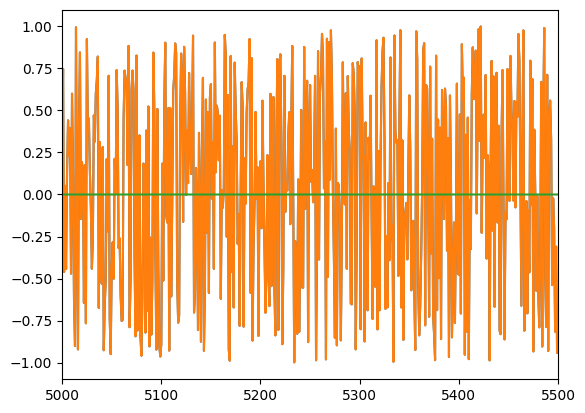

In [51]:
plt.plot(stim_data)
plt.plot(orig_stim_data)
delta = stim_data - orig_stim_data
plt.plot(delta)
plt.xlim(5000, 5500)


In [23]:
file_parameters

{}

In [14]:
import datetime
print(file_parameters["datetime"])


2024-01-17 10:28:56


datetime.datetime(2024, 1, 17, 10, 28, 56, tzinfo=tzfile('America/New_York'))

In [88]:
session_start_time = datetime.datetime(
    2024, 1, 17, 10, 28, 56, tzinfo=tz.gettz("America/New_York")
)

nwbfile = NWBFile(
    session_description="Freefield stimuli, recording from ICx",  # required
    identifier=str(uuid4()),  # required
    session_start_time=session_start_time,  # required
    session_id="session_1234",  # optional
    experimenter=[
        "Ferger, Roland",
        "Bae, Andrea J",
    ],  # optional
    lab="José Luis Peña",  # optional
    institution="Albert Einstein College of Medicine",  # optional
    # experiment_description="I went on an adventure to reclaim vast treasures.",  # optional
)

nwbfile.subject = Subject(
    subject_id="001",
    age="P90D",
    description="mouse 5",
    species="Mus musculus",
    sex="M",
)

nwbfile.add_trial_column(name="azimuth", description="stimulus position in azimuth")

for itrial in tqdm(range(10_000)):
    nwbfile.add_trial(
        start_time=itrial * trial_len_s_effective,
        stop_time=(itrial + 1) * trial_len_s_effective,
        azimuth=0.0,
    )
np.unique(np.diff(np.asarray(nwbfile.trials.to_dataframe()[['start_time', "stop_time"]]), axis=1))

100%|██████████| 10000/10000 [00:56<00:00, 176.00it/s]


array([2.4999936, 2.4999936, 2.4999936, 2.4999936, 2.4999936, 2.4999936,
       2.4999936, 2.4999936, 2.4999936, 2.4999936, 2.4999936, 2.4999936])

In [89]:
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x2558847841344
Fields:
  colnames: ['start_time' 'stop_time' 'azimuth']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    azimuth <class 'hdmf.common.table.VectorData'>
  )
  description: experimental trials
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

[9.09494702e-13 4.54747351e-13 5.68434189e-14 1.42108547e-14
 3.55271368e-15 3.55271368e-15 7.10542736e-15 2.84217094e-14
 1.13686838e-13 2.27373675e-13 1.81898940e-12]


True

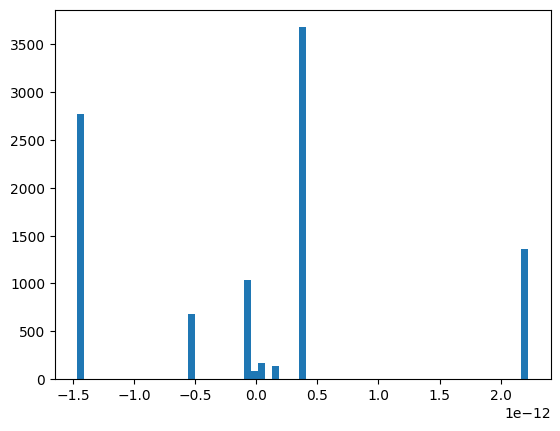

In [93]:
import matplotlib.pyplot as plt

d, c = np.unique(np.diff(np.asarray(nwbfile.trials.to_dataframe()[['start_time', "stop_time"]]), axis=1), return_counts=True)
print(np.diff(d))

plt.bar(
    d-trial_len_s_effective, c, width=np.median(np.diff(np.sort(d)))
)
np.allclose(np.diff(d), 0)

Text(0.5, 0, 'Experiment time [hours]')

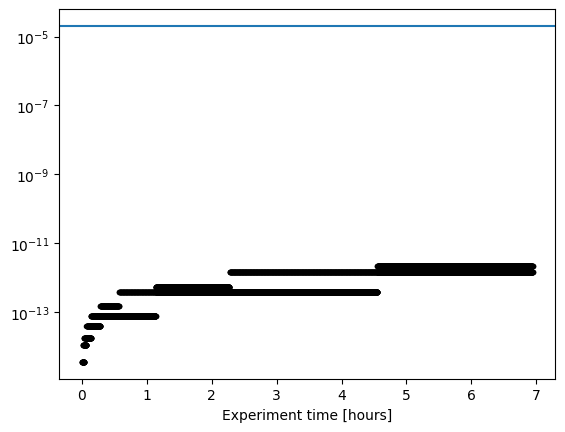

In [94]:
from matplotlib.axes import Axes

ax: Axes
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(
    np.arange(len(nwbfile.trials)) * trial_len_s_effective / 3600,
    np.abs(
        np.diff(
            np.asarray(nwbfile.trials.to_dataframe()[["start_time", "stop_time"]]),
            axis=1,
        )
        - trial_len_s_effective
    ),
    ".k",
)
ax.axhline(1 / samplingrate)
ax.set_xlabel("Experiment time [hours]")